In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/data.h5
/kaggle/input/fake-news-detection/data.csv


In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
file_path = '../input/fake-news-detection/data.csv'
data = pd.read_csv(file_path)
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [4]:
data.shape

(4009, 4)

The dataset contains 4009 rows and 4 columns,

URLs : URL of the news
Headline : Headline of the news
Body : News description
Label : 0 for fake news and 1 for true news

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   URLs      4009 non-null   object
 1   Headline  4009 non-null   object
 2   Body      3988 non-null   object
 3   Label     4009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.4+ KB


In [6]:
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

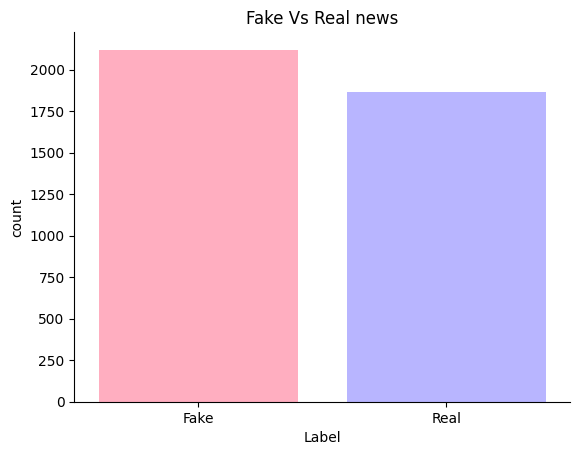

In [7]:
# making a bar plot to count the frequency of 
# fake and real news
sns.countplot(x='Label', 
              data=data,
              palette=['#ffaec0', '#b8b5ff'],
              saturation=1)
sns.despine()
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Fake Vs Real news');

In our dataset, we have more number of fake news as compare to real news. However, there is no huge difference in the ratio so the dataset is somewhat unbalanced and it is fine.

In [8]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()

In [9]:
fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})

In [10]:
rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,abcnews.go.com,57,0
1,beforeitsnews.com,0,1681
2,bleacherreport.com,8,0
3,clarivate.com,3,0
4,cnn.it,1,0
5,dailybuzzlive.com,0,99
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,money.cnn.com,49,0
9,reuters.com,1,0


we observed that websites are only posting either fake news or real news but not both of them means one website is only posting one type of news either fake or real but not both.

Most of the websites are posting real news, only four websites are there posting fake news.

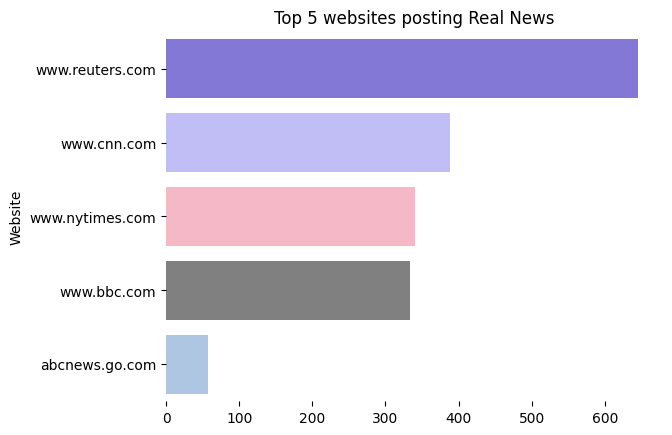

In [11]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

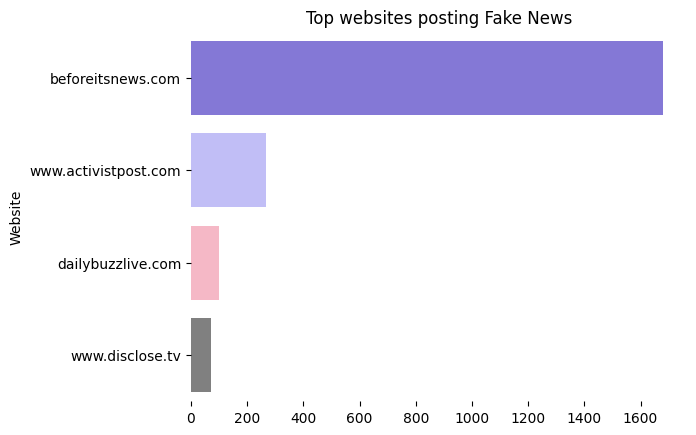

In [12]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

# Text Cleaning

In [13]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [14]:
import nltk
nltk.data.path.append("/kaggle/working/nltk_data")
nltk.download('wordnet', download_dir="/kaggle/working/nltk_data")
nltk.download('stopwords', download_dir="/kaggle/working/nltk_data")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
print(nltk.data.path)
stop_words = set(stopwords.words('english'))

['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/kaggle/working/nltk_data']


In [16]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import zipfile
zip_file_path = '/kaggle/working/nltk_data/corpora/wordnet.zip'
extract_to_path = '/kaggle/working/nltk_data/corpora/'

In [18]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [19]:
nltk.data.path.append('/kaggle/working/nltk_data/')

In [20]:
from nltk.corpus import wordnet

In [21]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus    

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

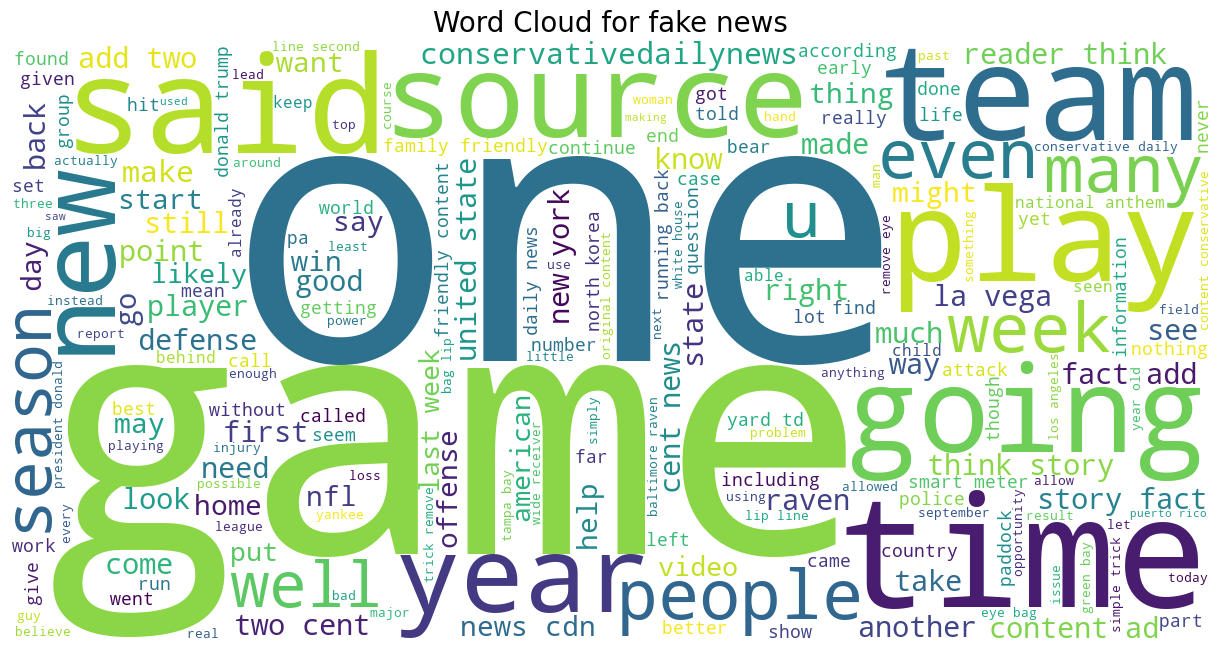

In [22]:
from wordcloud import WordCloud, STOPWORDS
sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(fake_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(fake_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for fake news', fontsize=20);

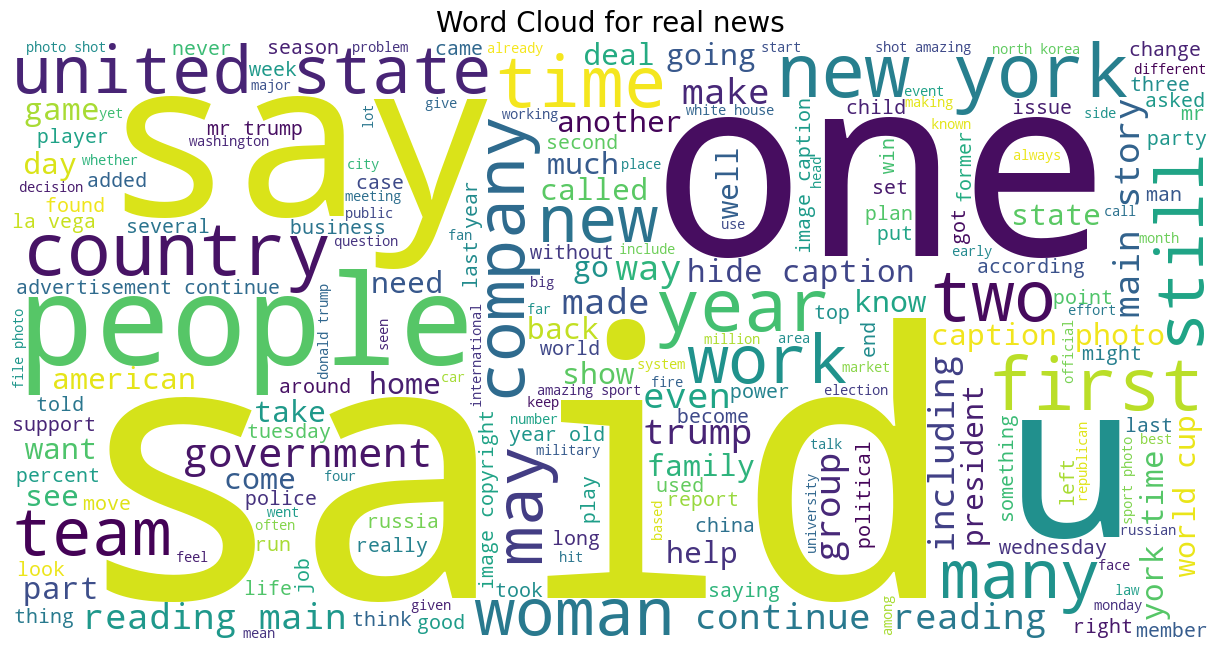

In [23]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(real_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(real_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for real news', fontsize=20);

# MODEL

In [24]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense

In [25]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

In [26]:
# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [27]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[3836, 2451, 4963, ..., 4668, 1643, 3975],
       [   0,    0,    0, ..., 2354, 3609, 1309],
       [4976,  646, 3657, ..., 3113, 1058, 1585],
       [   0,    0,    0, ..., 2298, 3657,  920],
       [   0,    0,    0, ..., 1404, 4330, 4496]], dtype=int32)

In [28]:
# Initialize the model
model = Sequential()
# Add embedding layer with reduced embedding dimensions
model.add(Embedding(5000, 50, input_length=sent_length))
# Switch to GRU or reduce LSTM units
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

from sklearn.model_selection import train_test_split
# Split the dataset into train and test
x = np.array(embedded_doc)
y = data.Label
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with a smaller batch size
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), 
                    epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8370 - loss: 0.5184 - val_accuracy: 0.9609 - val_loss: 0.1447
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9767 - loss: 0.0833 - val_accuracy: 0.9759 - val_loss: 0.0672
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9920 - loss: 0.0249 - val_accuracy: 0.9789 - val_loss: 0.0593
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9976 - loss: 0.0112 - val_accuracy: 0.9860 - val_loss: 0.0565
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 0.9819 - val_loss: 0.0541
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9860 - val_loss: 0.0597
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 8.5715e-04 - val_accuracy: 0.9880 - val_loss: 0.0570
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 5.4316e-04 - val_accuracy: 0.

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
pred = model.predict(test_x);

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


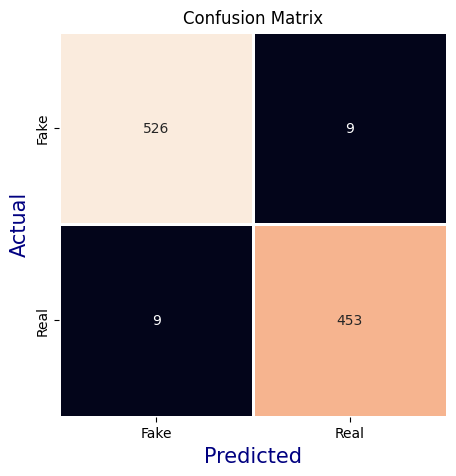

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert continuous predictions to binary (0 or 1) using a threshold
threshold = 0.5
binary_pred = [1 if p >= threshold else 0 for p in pred]

# Calculate confusion matrix with binary predictions
cm = confusion_matrix(test_y, binary_pred)

# Plotting the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15)
plt.show()


In [33]:
from sklearn.metrics import accuracy_score

# Convert continuous predictions to binary (0 or 1) using a threshold
threshold = 0.5
binary_pred = [1 if p >= threshold else 0 for p in pred]

# Calculate accuracy
accuracy = accuracy_score(test_y, binary_pred)
print("Accuracy of the model:", accuracy)


Accuracy of the model: 0.9819458375125376


In [34]:
import tensorflow as tf

# Save the Keras model as an .h5 file (optional step)
keras_file = "fakenews.h5"
tf.keras.models.save_model(model, keras_file)